# 第二章 测量权重和偏差 W&B

在这一节中，我们将学习如何在机器学习训练代码中测量权重和偏差 (Weights and biases)。当我们训练机器学习模型时，很多事情都可能出错。wandb 将帮助我们监控、调试和评估我们的流水线 (pipeline)。  
只需要几行代码，我们就可以试试监控指标，CPU 和 GPU。我们可以对代码进行版本监控，重现模型检查点 (checkpoints)，并在集中式的、交互式的仪表板中可视化预测。  
我们可以进行评估模型、讨论 bugs，并使用可配置报告 (configurable reports) 演示进度。

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#一将权重和偏差纳入训练过程" data-toc-modified-id="一、将权重和偏差纳入训练过程">一、将权重和偏差纳入训练过程</a></span></li>
        <li><span><a href="#二实战演练——前期准备工作" data-toc-modified-id="二、实战演练——前期准备工作">二、实战演练——前期准备工作</a></span></li>
        <li><span><a href="#三实战演练——使用wandb云平台" data-toc-modified-id="三、实战演练——使用wandb云平台">三、实战演练——使用wandb云平台</a></span></li>
        <li>
        <span><a href="#四实战演练——训练模型" data-toc-modified-id="四、实战演练——训练模型">四、实战演练——训练模型</a></span>
        <ul class="toc-item">
                <li><span><a href="#41同步运行结果" data-toc-modified-id="4.1 同步运行结果">4.1 同步运行结果</a></span></li>
                <li><span><a href="#42项目页" data-toc-modified-id="4.2 项目页">4.2 项目页</a></span></li>
        </ul>
        </li>
    </ul>
</div>

## 一、将权重和偏差纳入训练过程  
  
首先安装 wandb 库。导入 wandb 库。理想情况下，我们已经在对象中构造了超参数，否则需要将它们一起放到一个配置中。然后启动 wandb。通常情况下，一次运行对应着一次机器学习实验。开始时，我们通过 wandb.init 传递项目名称和配置对象。然后用训练模型的代码继续。当我们到达某点想跟踪和可视化时，可以使用 wandb.log 来记录它们。如果我们用的是 notbook ，建议在最后使用 wandb.finish 。

In [ ]:
!pip install wandb
import wandb

# 1. 组织超参数
config = {'learning_rate': 0.001}

# 2. 启动wandb
wandb.init(project='gpt5', config=config)

# 在这里模型训练

# 3. 记录指标来可视化表现
wandb.log({"loss": loss})

# 4. 在notbook里运行时，记得结束
wandb.finish()

## 二、实战演练——前期准备工作  
  
在这个训练脚本中，我们将训练一个精灵分类模型。精灵是一个16\*16像素小图像，我们的目标对精灵分为五类中的一个（图中有一类没画）。

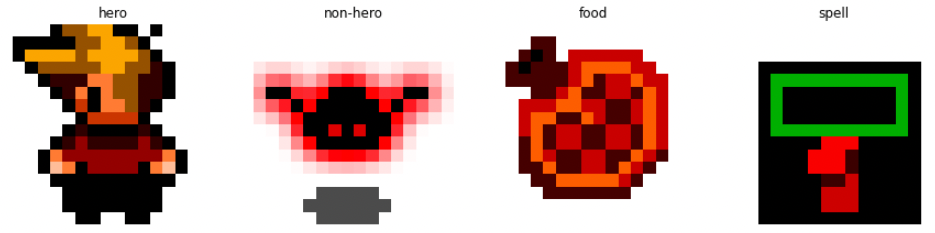

In [1]:
# 导入相应库
import math
from pathlib import Path
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from utilities import get_dataloaders

import wandb

这里我们定义了一个简单的有两个线性层的分类器模型。

In [2]:
INPUT_SIZE = 3 * 16 * 16
OUTPUT_SIZE = 5
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ["hero", "non-hero", "food", "spell", "side-facing"]
DATA_DIR = Path('./data/')
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "有 Dropout 的简单多层感知机"
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
        nn.BatchNorm1d(HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    ).to(DEVICE)

In [3]:
# 定义一个配置对象来储存我们的超参数
config = SimpleNamespace(
    epochs = 2,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [4]:
def train_model(config):
    "用已知的配置来训练模型"
    
    # 启用 wandb 来传递项目名和配置对象
    wandb.init(
        project="dlai_intro",
        config=config,
    )

    # 获取数据
    train_dl, valid_dl = get_dataloaders(DATA_DIR, 
                                         config.batch_size, 
                                         config.slice_size, 
                                         config.valid_pct)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # 一个简单的多层感知机模型
    model = get_model(config.dropout)

    # 制取损失和优化器
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            # 记录相应指标
            wandb.log(metrics)
            
        # 计算验证指标，记录上最近epoch的图像
        val_loss, accuracy = validate_model(model, valid_dl, loss_func)
        # 计算训练和验证指标
        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": accuracy
        }
        # 记录相应指标
        wandb.log(val_metrics)
    
    # 结束
    wandb.finish()

In [5]:
def validate_model(model, valid_dl, loss_func):
    "在验证集上计算模型的表现"
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # 向前传递
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # 计算准确度并累积
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


## 三、实战演练——使用 wandb 云平台  

虽然本地也可部署，但有些麻烦！此处介绍云平台使用方法！  
wandb 对个人和学术使用都是免费的，所以鼓励注册！这样，我们就可以跟踪实验结果了。

我们也可以在匿名模式下运行代码  
若想重新登陆请在终端输入 wandb login --relogin

In [6]:
wandb.login(anonymous="allow")

wandb: Currently logged in as: 1450620249 (random-walk). Use `wandb login --relogin` to force relogin


True

第一次登陆会弹出两次弹窗，第一次输入2，在注册后，点击划红线网址，复制API并粘贴至第二次弹窗就成功了

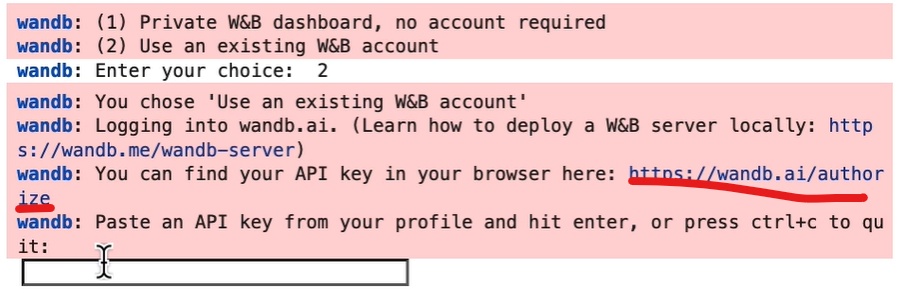

## 四、实战演练——训练模型  

让我们用默认的配置训练模型，并学习在云平台如何查看

In [9]:
train_model(config)

  0%|          | 0/2 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train/example_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▇█▇▇▇▆▇▅▆▆▅▅▄▅▄▅▃▄▅▃▄▄▃▃▄▂▄▃▂▁▃▂▁▃▂▁▁▃▁
val/val_accuracy,▁█
val/val_loss,█▁
train/epoch,2
train/example_ct,16000
train/train_loss,1.3472
val/val_accuracy,0.6155
val/val_loss,1.2503


### 4.1 同步运行结果
同步这个运行，在上述结果中 Syncing run 后点击链接

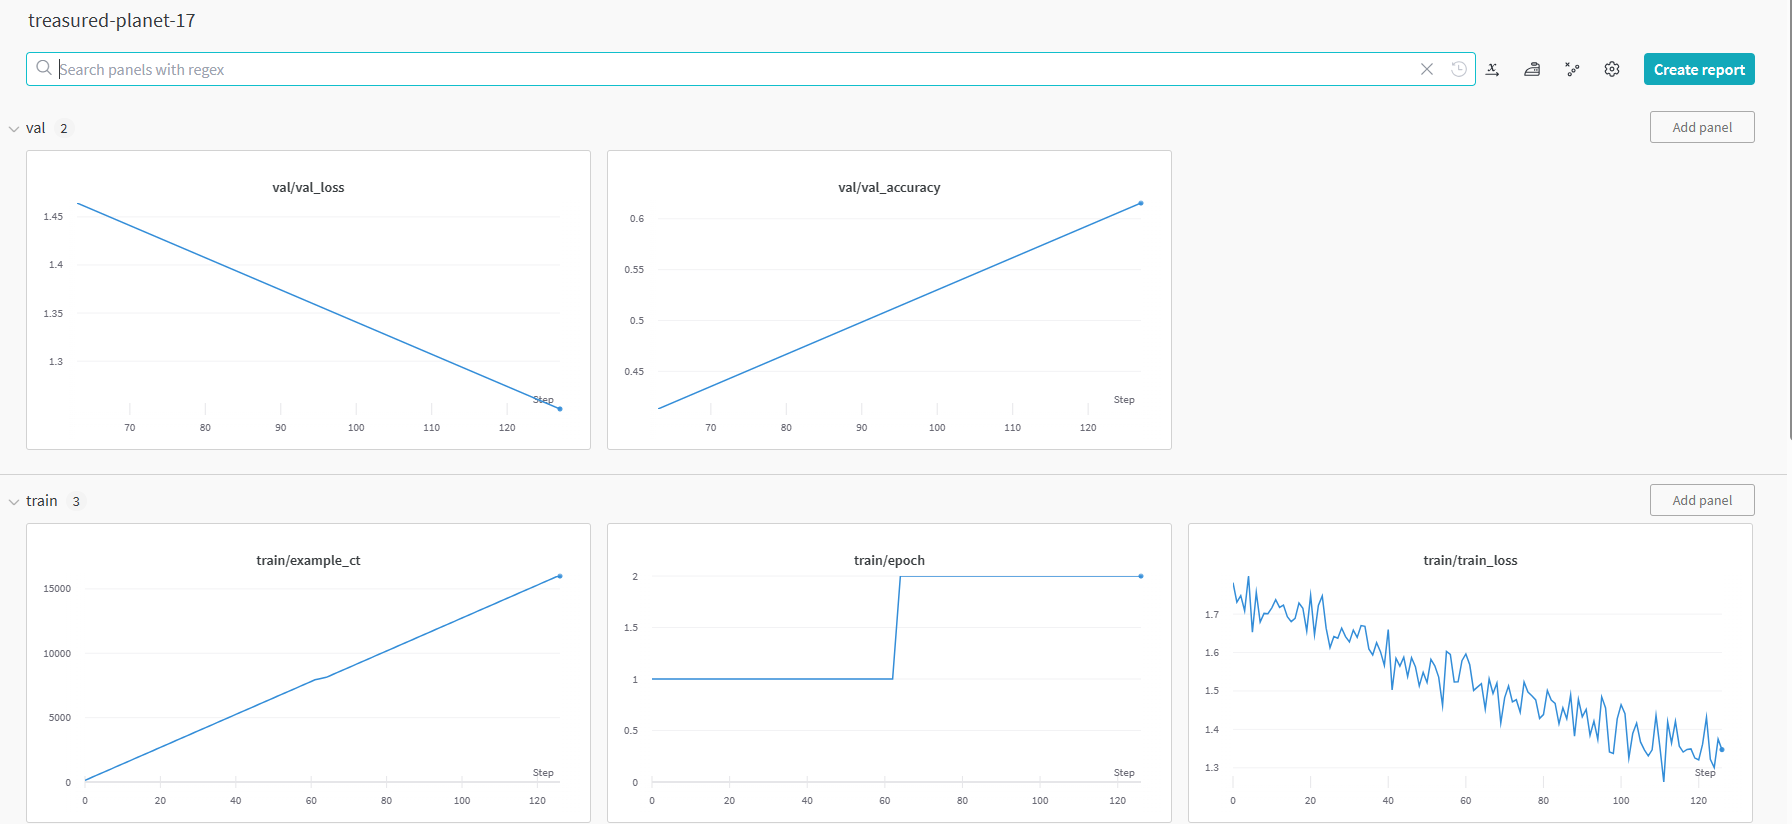

### 4.2 项目页  

我们也可以打开项目页，点击上述结果中 View project at 后面的链接，在这个网页我们可以相关数据

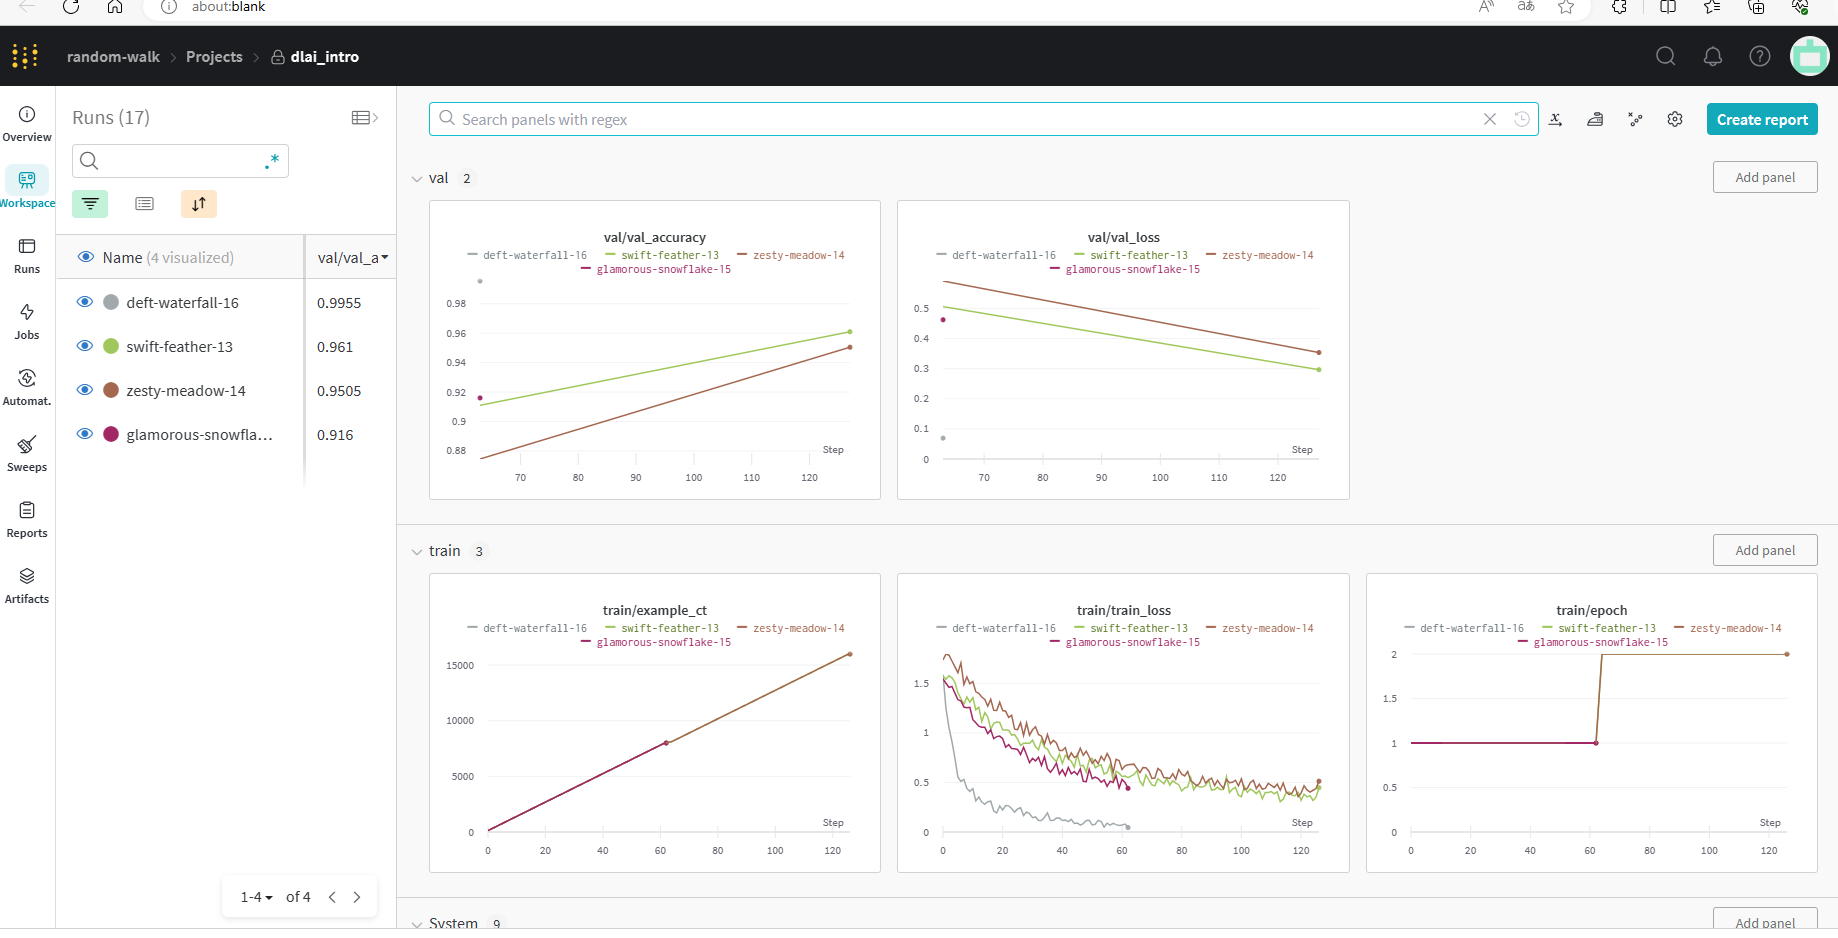

此时，val_accuracy 不高，我们可以尝试训练更长时间或者改变学习率来提升模型

In [12]:
# 我们现在改变学习率为1e-4 
# 然后我们看看这会怎样影响我们的结果
config.lr = 1e-4
train_model(config)

  0%|          | 0/2 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train/example_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,██▇▆▅▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁
val/val_accuracy,▁█
val/val_loss,█▁
train/epoch,2
train/example_ct,16000
train/train_loss,0.3718
val/val_accuracy,0.9605
val/val_loss,0.30892


在项目界面，我们可以自行探索相关事项！！！  
我们在下面尝试改变其他超参数，然后在项目页面一起比较结果！！！

In [13]:
config.dropout = 0.1
config.epochs = 1
train_model(config)

  0%|          | 0/1 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
val/val_accuracy,▁
val/val_loss,▁
train/epoch,1
train/example_ct,8000
train/train_loss,0.50432
val/val_accuracy,0.922
val/val_loss,0.47382


In [14]:
config.lr = 1e-3
train_model(config)

  0%|          | 0/1 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁
val/val_loss,▁
train/epoch,1
train/example_ct,8000
train/train_loss,0.06335
val/val_accuracy,0.9925
val/val_loss,0.05326


比较所有训练，我们关注到2次结果的train_loss很低而且val_accuracy结果很好

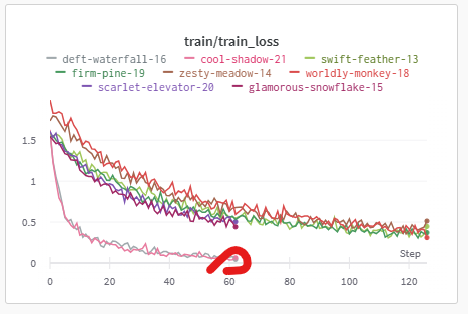

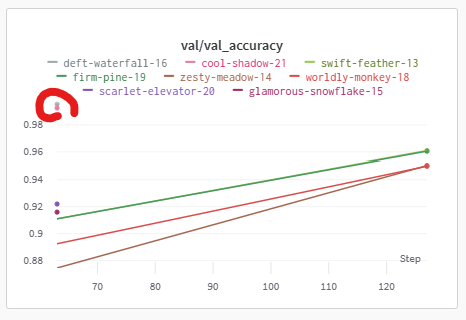

我也可以采用另一种方式来查看结果，点击 Expand

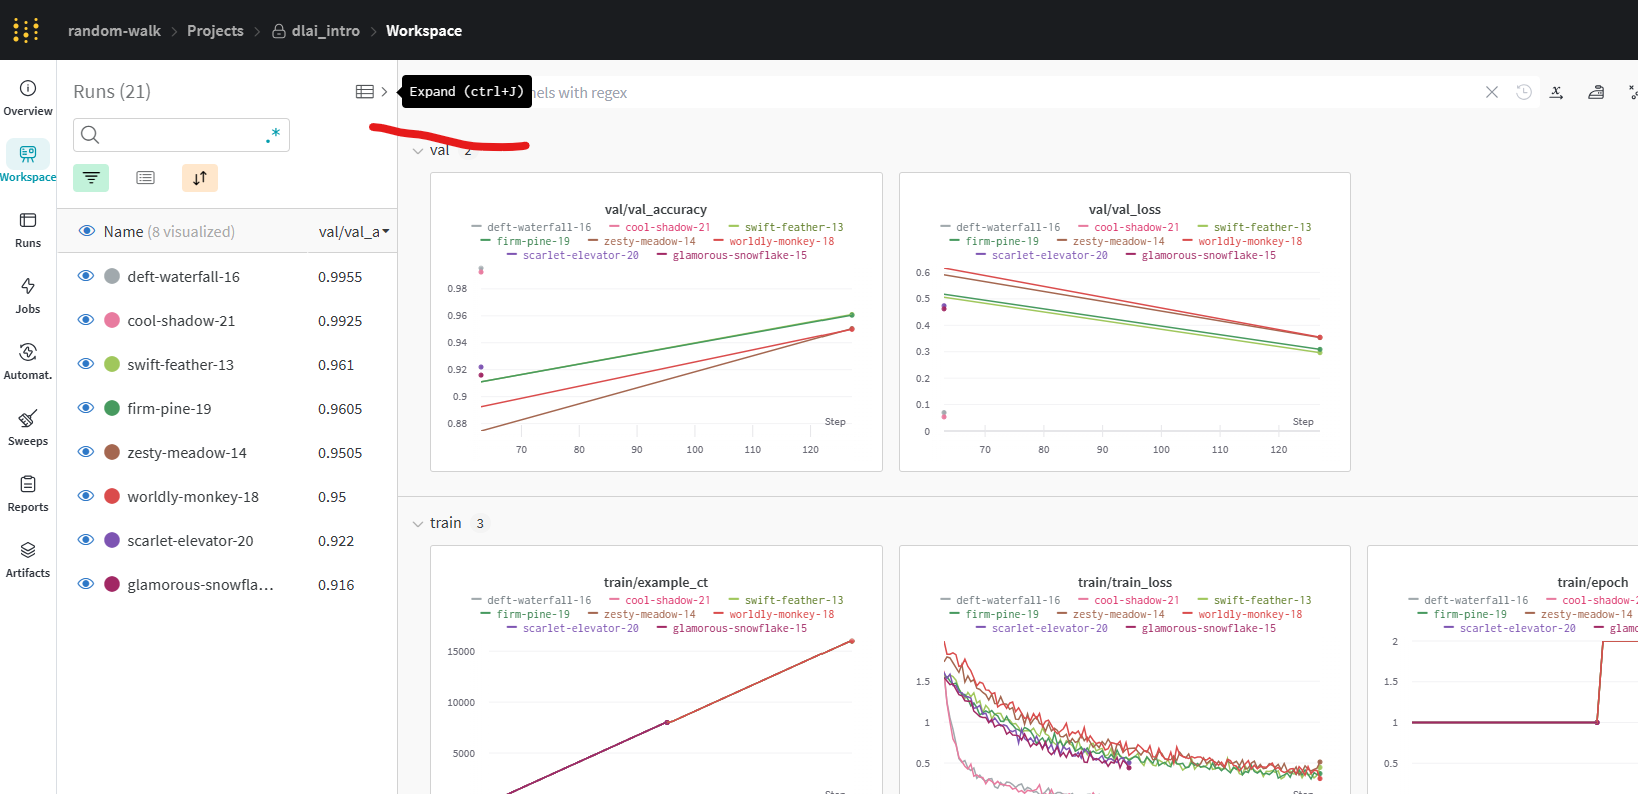

在这里，你可以通过“三个点”进行相关操作。另外，由于我们对 accuracy 感兴趣，可以点击 Columns，搜索 accuracy 后可以进行相关固定 (Pin)，返回先前页面便可以查看到置顶的数据。最后，点击右上角的 Collapse 即可退出该页面。

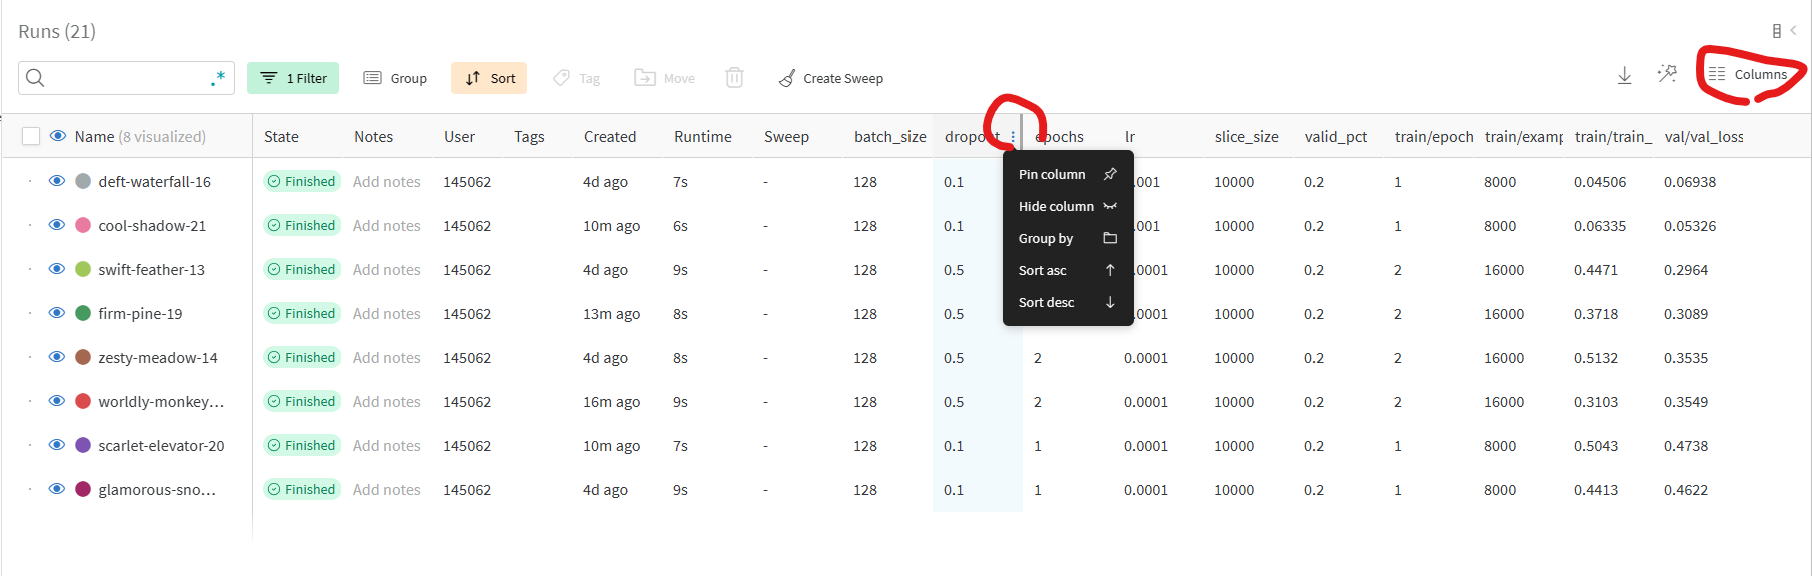

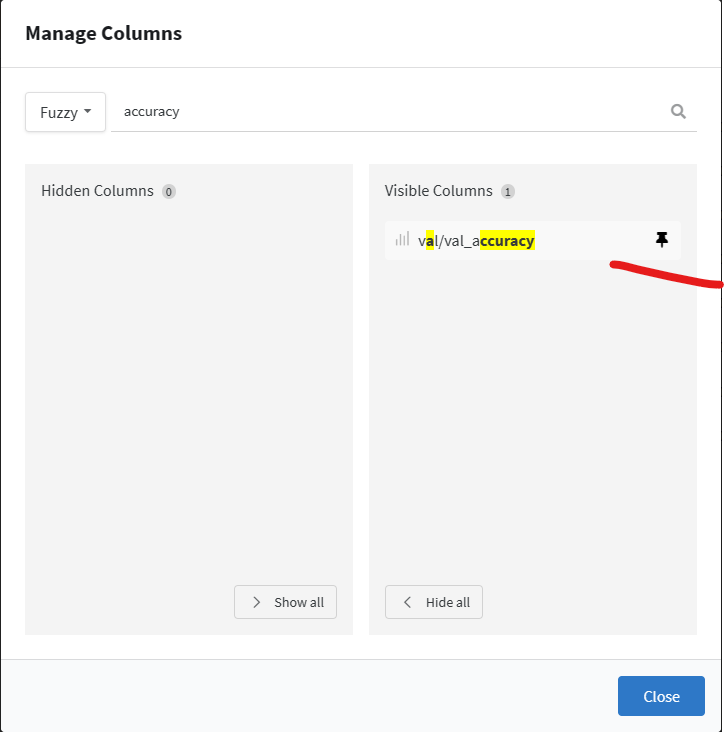

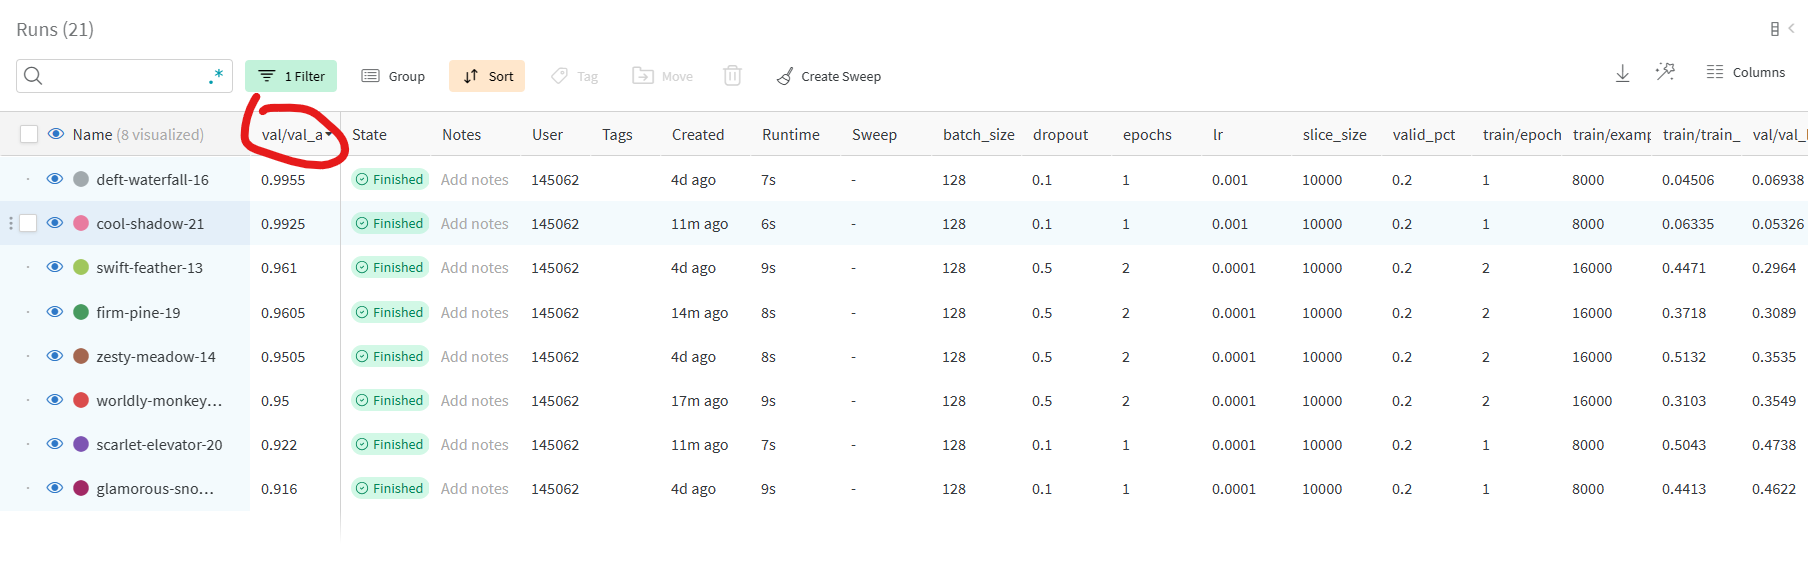

另外，我们也可以进行筛选和排序

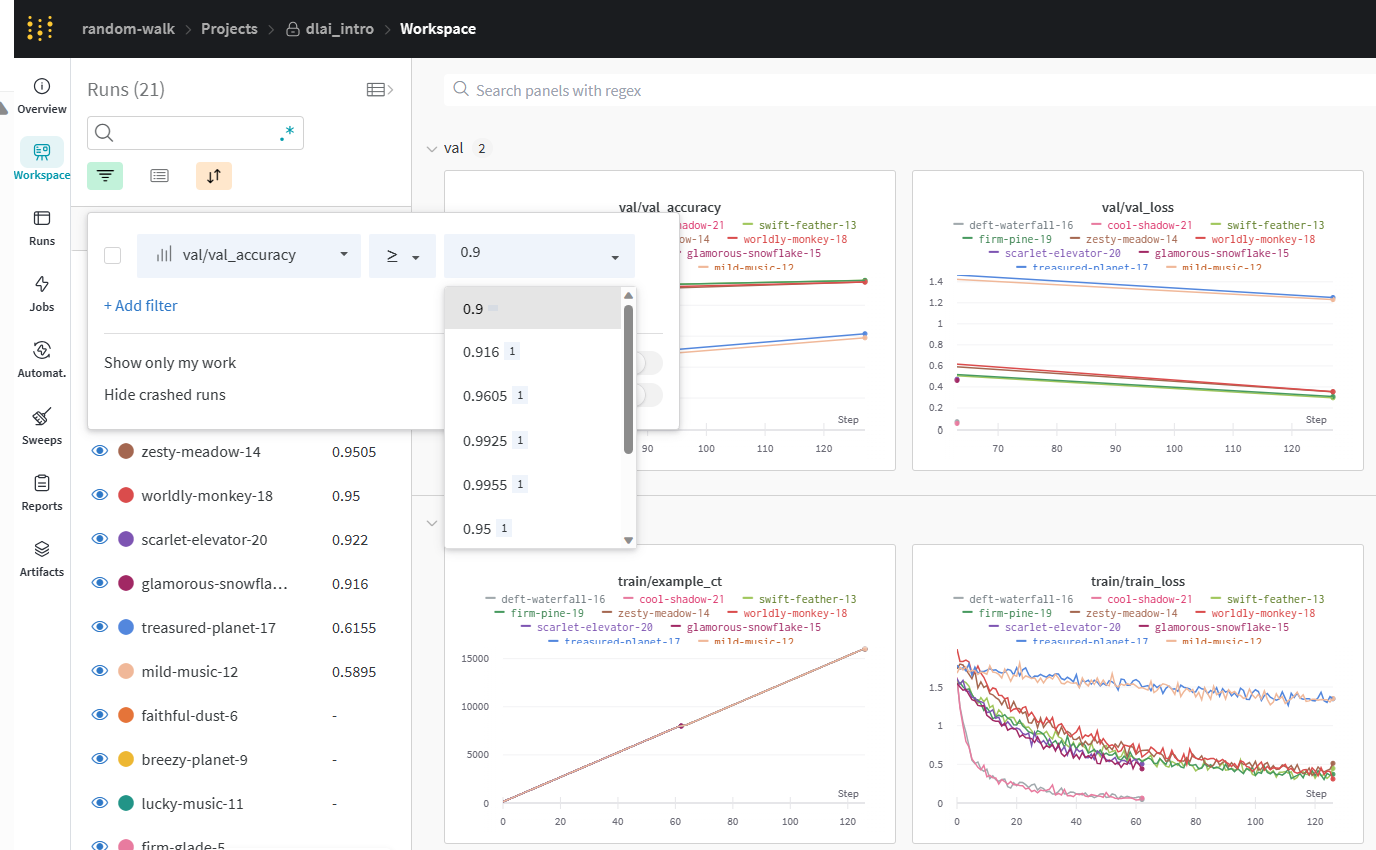

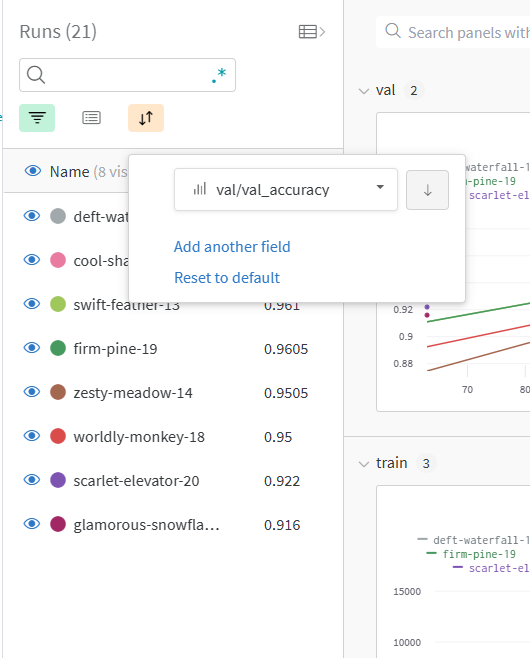

最后，我们可以查看最好结果的训练相关信息

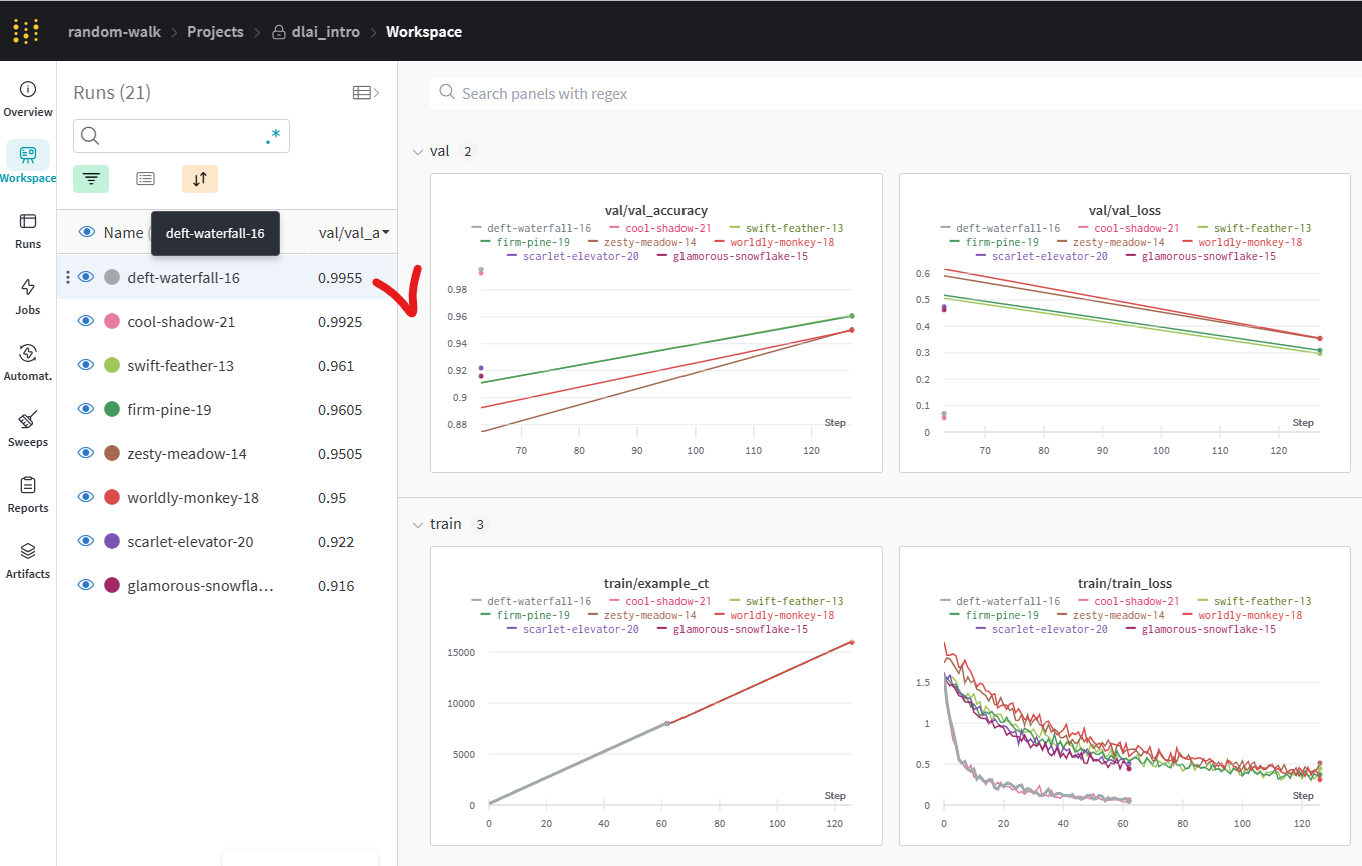

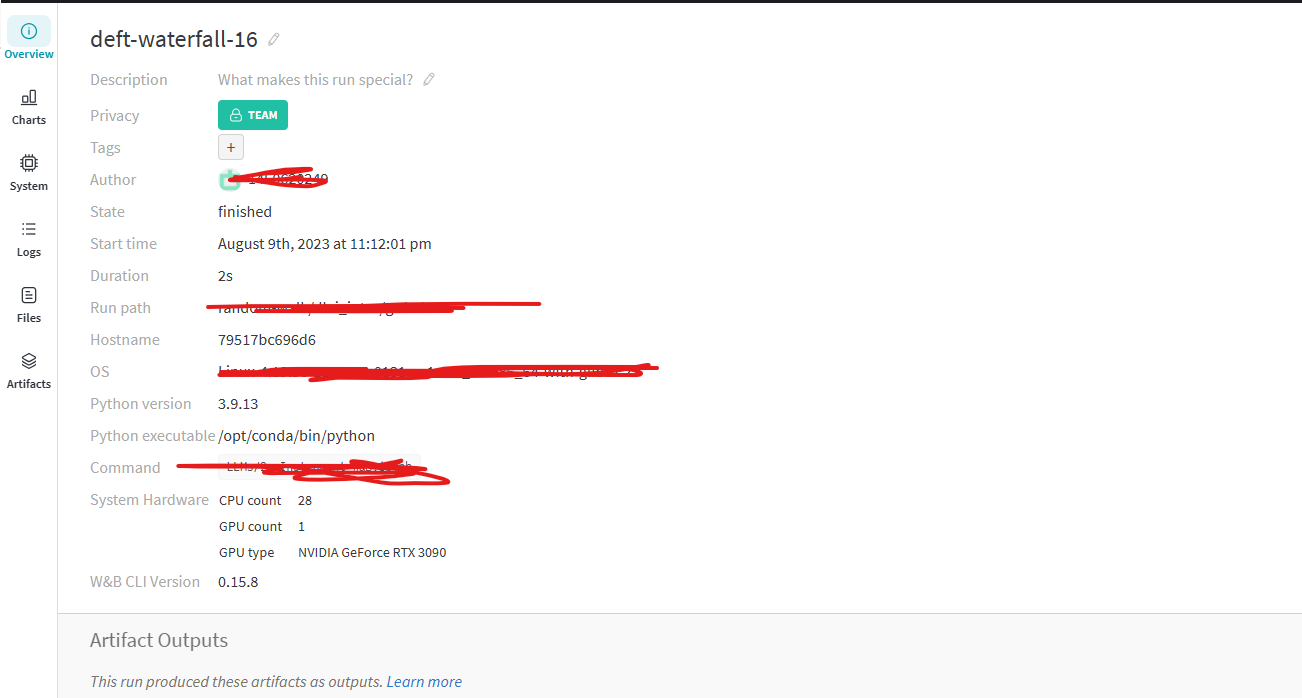